In [17]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold, cross_val_score



In [18]:
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=5.0):
        self.threshold = threshold
        self.features_to_keep = None
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        # Store feature names from the training data
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns
        else:
            self.feature_names_in_ = [f'feature_{i}' for i in range(X.shape[1])]
        
        # Convert X to DataFrame if it is a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        # Calculate VIF for each feature
        vif_data = pd.DataFrame()
        vif_data["feature"] = X.columns
        vif_data["VIF"] = [sm.OLS(X[col], sm.add_constant(X.drop(columns=[col]))).fit().rsquared for col in X.columns]
        vif_data["VIF"] = [1 / (1 - rsq) if rsq < 1 else np.inf for rsq in vif_data["VIF"]]
        
        # Keep features with VIF below the threshold
        self.features_to_keep = vif_data[vif_data["VIF"] < self.threshold]["feature"].tolist()
        return self

    def transform(self, X):
        # Convert X to DataFrame if it is a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        # Return DataFrame with only the selected features
        return X[self.features_to_keep]

    def attrib(self, X):
        # Convert X to DataFrame if it is a NumPy array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        
        # Return selected features and their VIF values
        return {"features_to_keep": self.features_to_keep, "VIF Values": X[self.features_to_keep]}


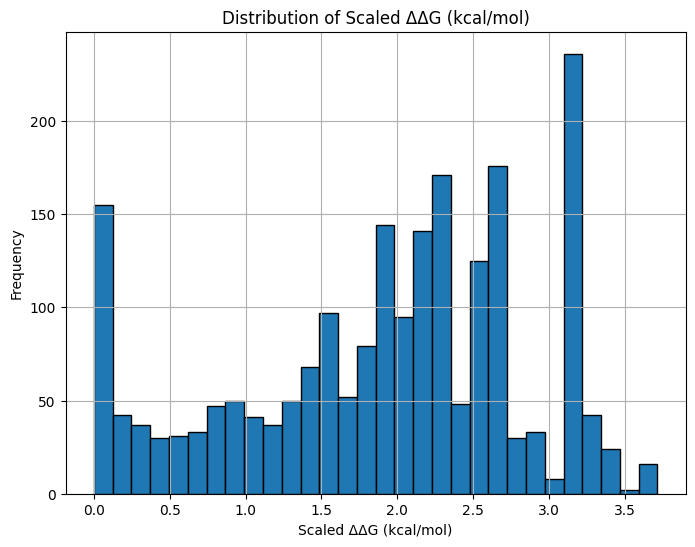

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'scaled_output_ddG_constant_ee_kcal.xlsx'
df = pd.read_excel(file_path)

plt.figure(figsize=(8,6))
plt.hist(df['Scaled ΔΔG (kcal/mol)'], bins=30, edgecolor='black')
plt.title('Distribution of Scaled ΔΔG (kcal/mol)')
plt.xlabel('Scaled ΔΔG (kcal/mol)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


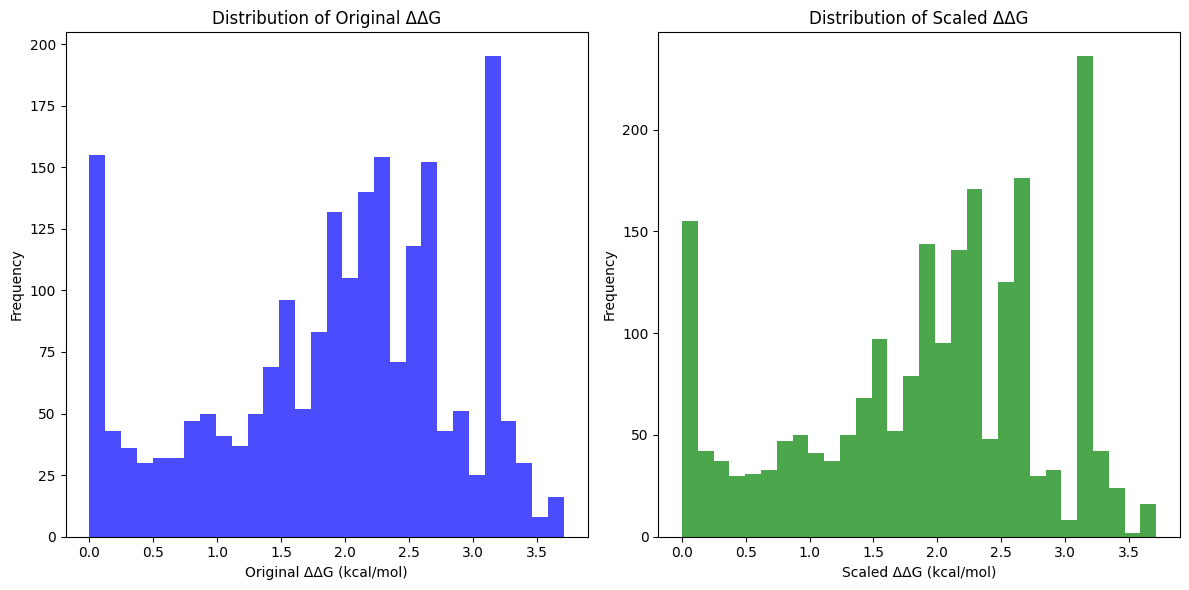

In [20]:
import matplotlib.pyplot as plt

file_path = 'scaled_output_ddG_constant_ee_kcal.xlsx'
df1 = pd.read_excel(file_path)

plt.figure(figsize=(12, 6))

# Original ddG distribution
plt.subplot(1, 2, 1)
plt.hist(df1['ddG'].dropna(), bins=30, alpha=0.7, color='blue')
plt.title('Distribution of Original ΔΔG')
plt.xlabel('Original ΔΔG (kcal/mol)')
plt.ylabel('Frequency')

# Scaled ddG distribution
plt.subplot(1, 2, 2)
plt.hist(df1['Scaled ΔΔG (kcal/mol)'].dropna(), bins=30, alpha=0.7, color='green')
plt.title('Distribution of Scaled ΔΔG')
plt.xlabel('Scaled ΔΔG (kcal/mol)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Frequency')

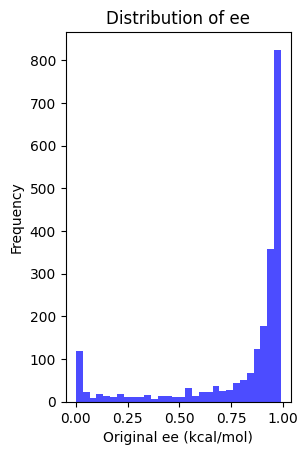

In [21]:

# Original ddG distribution
plt.subplot(1, 2, 1)
plt.hist(df1['ee'].dropna(), bins=30, alpha=0.7, color='blue')
plt.title('Distribution of ee')
plt.xlabel('Original ee (kcal/mol)')
plt.ylabel('Frequency')


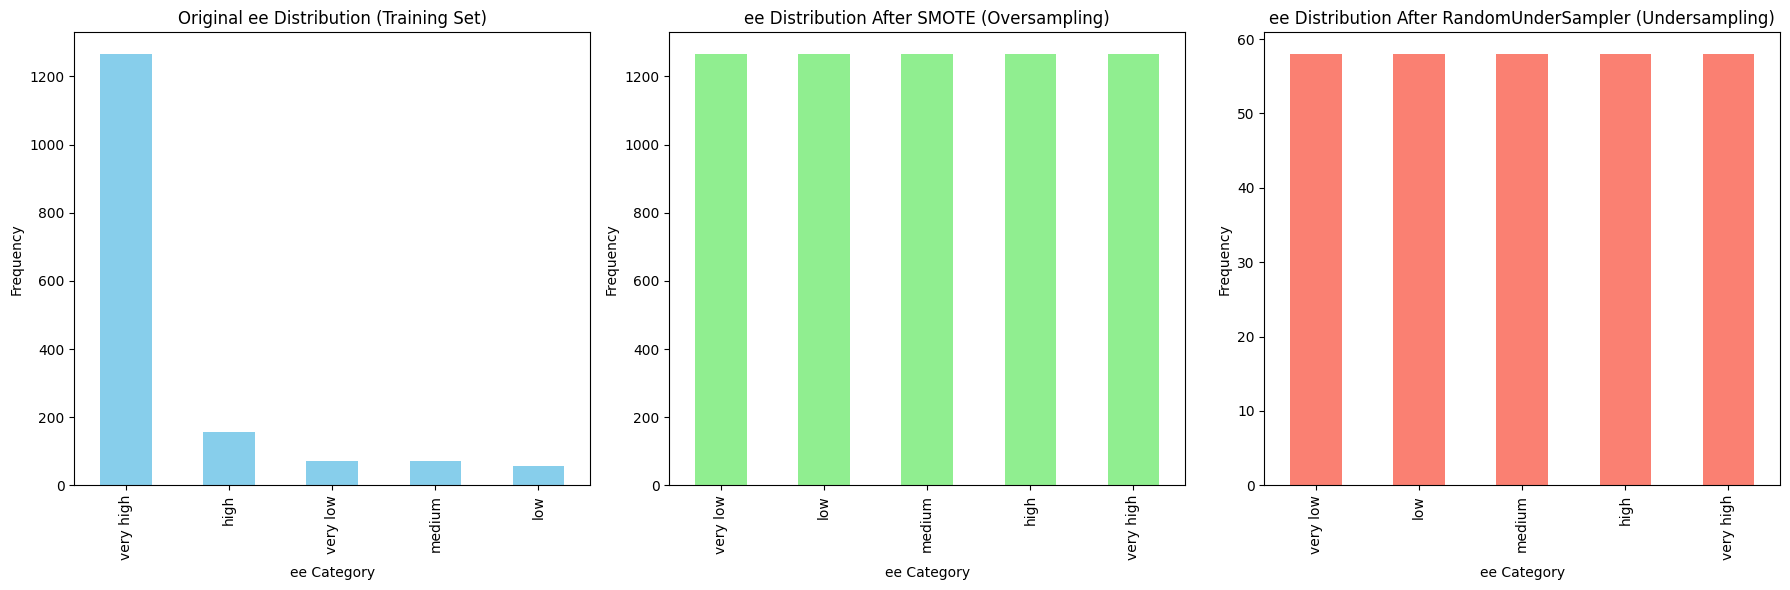

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Bin the 'ee' column into five categories
df['ee_category'] = pd.cut(df['ee'], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=['very low', 'low', 'medium', 'high', 'very high'])

# Drop rows with NaNs in 'ee' or 'ee_category'
df = df.dropna(subset=['ee', 'ee_category'])

# Separate features and target
X = df.drop(['ee', 'ee_category'], axis=1)  # Use the other columns as features
y = df['ee_category']  # Target is the binned ee categories

# Drop non-numeric columns from X
non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

# Impute missing values in X using mean imputation
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Separate Oversampling with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_oversampled, y_oversampled = smote.fit_resample(X_train, y_train)

# Separate Undersampling with RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

# Plotting the distributions before and after oversampling and undersampling
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original distribution
y_train.value_counts().plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Original ee Distribution (Training Set)')
axes[0].set_xlabel('ee Category')
axes[0].set_ylabel('Frequency')

# Distribution after SMOTE (Oversampling)
pd.Series(y_oversampled).value_counts().plot(kind='bar', color='lightgreen', ax=axes[1])
axes[1].set_title('ee Distribution After SMOTE (Oversampling)')
axes[1].set_xlabel('ee Category')
axes[1].set_ylabel('Frequency')

# Distribution after RandomUnderSampler (Undersampling)
pd.Series(y_undersampled).value_counts().plot(kind='bar', color='salmon', ax=axes[2])
axes[2].set_title('ee Distribution After RandomUnderSampler (Undersampling)')
axes[2].set_xlabel('ee Category')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Data shape after filtering for 'Tri_Q4': (711, 32)
Data shape after removing rows with Scaled ΔΔG (kcal/mol) = 0 and NaNs: (662, 32)
Data shape after dropping NaNs in 'ee': (662, 32)


/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Model: OLS
Best Parameters: {'model__fit_intercept': False}
Train R²: 0.9978, MAE: 0.0177
Test R²: 0.9967, MAE: 0.0191


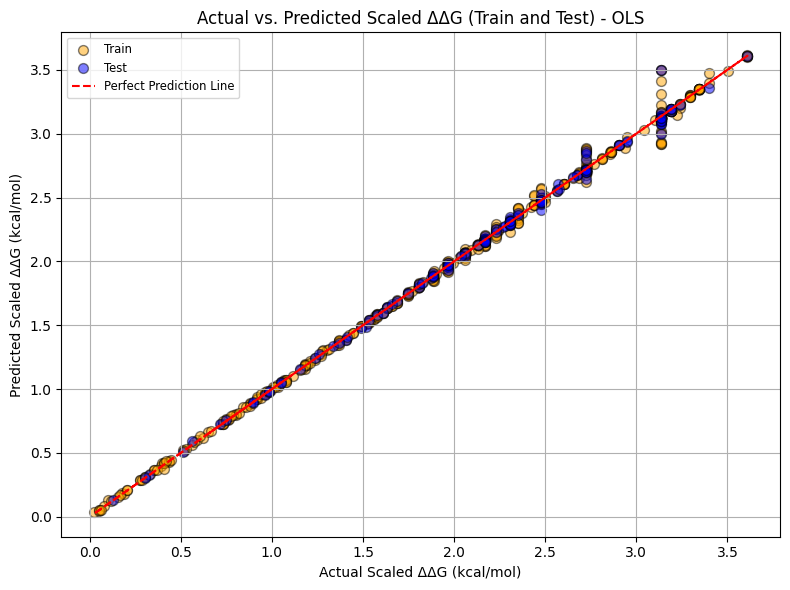


Model: PLS
Best Parameters: {'model__n_components': 4}
Train R²: 0.9837, MAE: 0.0861
Test R²: 0.9804, MAE: 0.0766


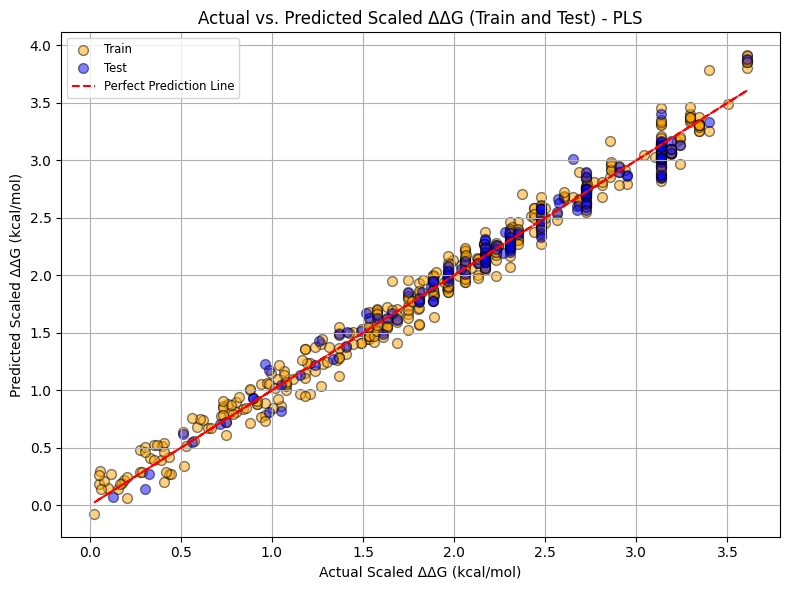


Model: Lasso
Best Parameters: {'model__alpha': 0.03058449429580245}
Train R²: 0.9760, MAE: 0.1058
Test R²: 0.9754, MAE: 0.0924


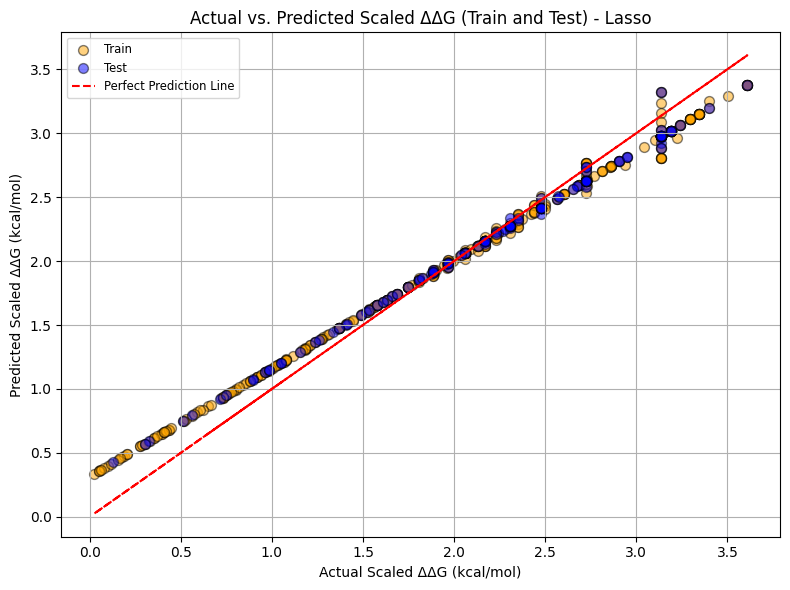


Model: Ridge
Best Parameters: {'model__alpha': 0.21584494295802448}
Train R²: 0.9977, MAE: 0.0203
Test R²: 0.9966, MAE: 0.0215


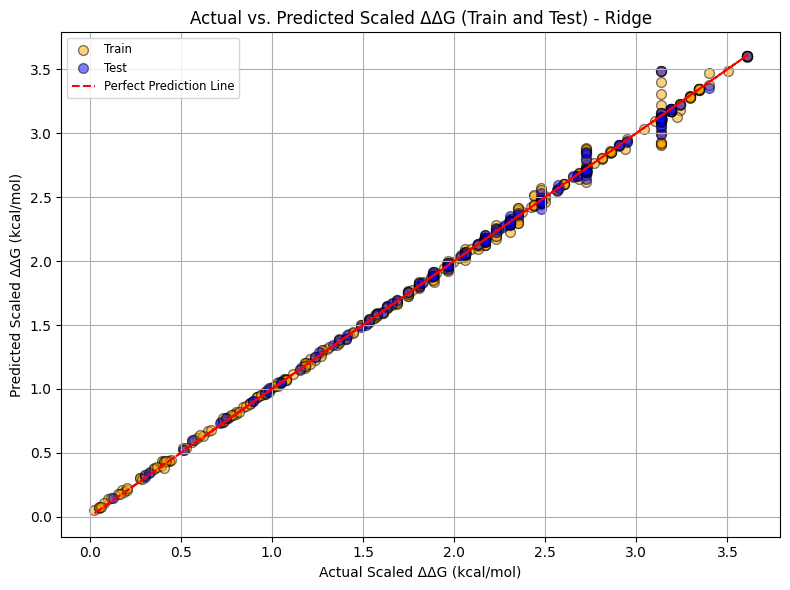


Model: SVR (Linear Kernel)
Best Parameters: {'model__C': 1.6601864044243653}
Train R²: 0.9955, MAE: 0.0439
Test R²: 0.9937, MAE: 0.0440


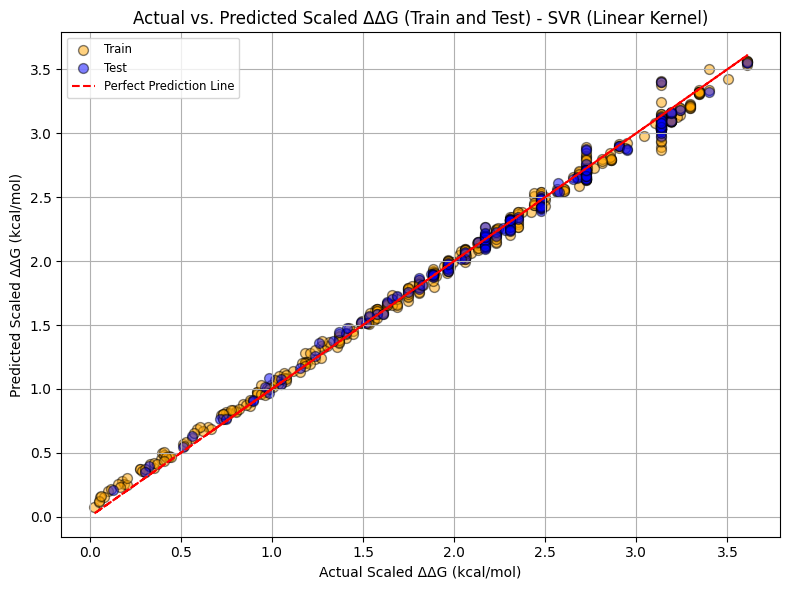


Model: SVR (Polynomial Kernel)
Best Parameters: {'model__C': 0.6808361216819946}
Train R²: 0.9921, MAE: 0.0651
Test R²: 0.9684, MAE: 0.0861


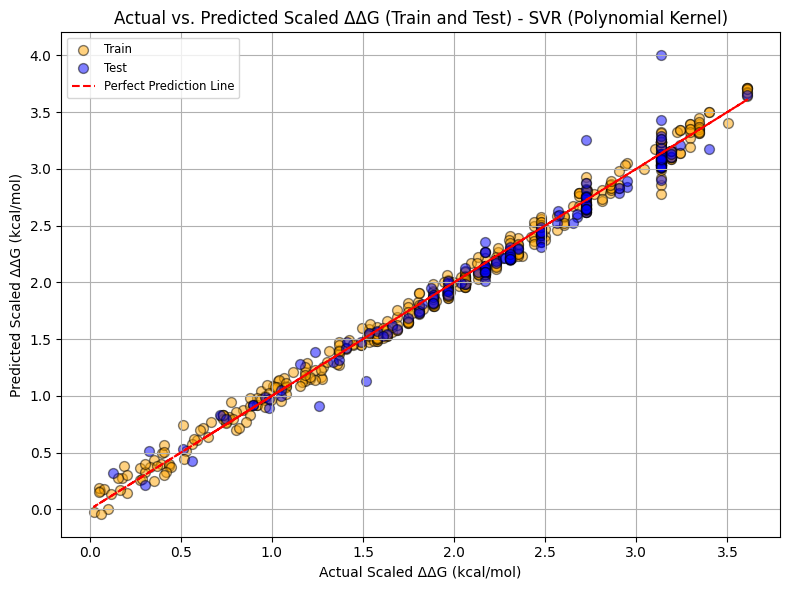


Model: Random Forest
Best Parameters: {'model__max_depth': 12, 'model__min_samples_split': 2, 'model__n_estimators': 58}
Train R²: 0.9998, MAE: 0.0051
Test R²: 0.9980, MAE: 0.0139


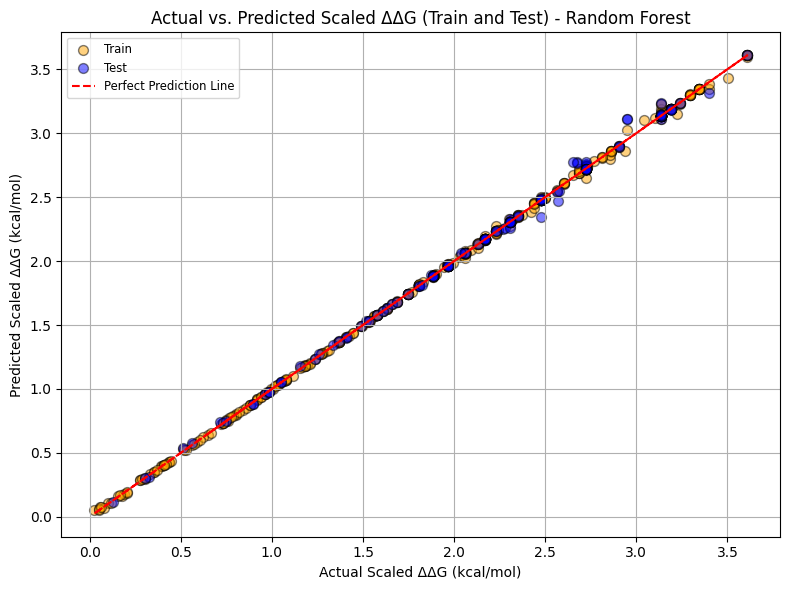


Model: Gradient Boosting
Best Parameters: {'model__learning_rate': 0.14777466758976016, 'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 113}
Train R²: 1.0000, MAE: 0.0009
Test R²: 0.9985, MAE: 0.0111


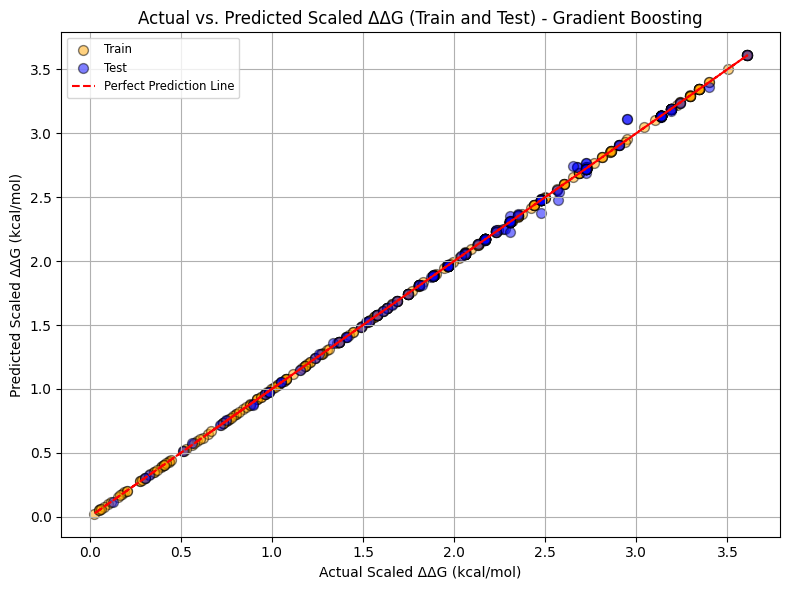

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import uniform, randint

df_triQ4 = df1[df1['_Alkene_Type'] == 'Tri_Q4'].copy()
print(f"Data shape after filtering for 'Tri_Q4': {df_triQ4.shape}")

# Remove rows where Scaled ΔΔG (kcal/mol) = 0 or is missing
df_triQ4 = df_triQ4[df_triQ4['Scaled ΔΔG (kcal/mol)'] != 0].dropna(subset=['Scaled ΔΔG (kcal/mol)'])
print(f"Data shape after removing rows with Scaled ΔΔG (kcal/mol) = 0 and NaNs: {df_triQ4.shape}")

# Drop rows with NaNs in 'ee'
df_triQ4 = df_triQ4.dropna(subset=['ee'])
print(f"Data shape after dropping NaNs in 'ee': {df_triQ4.shape}")

X = df_triQ4.drop(['ee', '_Alkene_Type', 'Scaled ΔΔG (kcal/mol)'], axis=1) 
y = df_triQ4['Scaled ΔΔG (kcal/mol)'] 

non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X_train.columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

best_models = {}

# Define models and their hyperparameter spaces
models = {
    'OLS': (LinearRegression(), {'model__fit_intercept': [True, False]}),
    'PLS': (PLSRegression(), {'model__n_components': randint(1, 5)}),
    'Lasso': (Lasso(), {'model__alpha': uniform(0.01, 1)}),
    'Ridge': (Ridge(), {'model__alpha': uniform(0.01, 10)}),
    'SVR (Linear Kernel)': (SVR(kernel='linear'), {'model__C': uniform(0.1, 10)}),
    'SVR (Polynomial Kernel)': (SVR(kernel='poly', degree=3), {'model__C': uniform(0.1, 10)}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__max_depth': randint(1, 20),
        'model__min_samples_split': randint(2, 10)
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(1, 10),
        'model__min_samples_split': randint(2, 10)
    })
}

for model_name, (model, param_distributions) in models.items():
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    
    # RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=20, 
                                scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=42)

    # Fit the RandomizedSearchCV on the training data
    search.fit(X_train_processed, y_train)

    # Best model from RandomizedSearchCV
    best_pipe = search.best_estimator_

    # Store the best model in the dictionary for later use
    best_models[model_name] = best_pipe

    # Predict on training data
    pred_X_train = best_pipe.predict(X_train_processed)
    r2_train = r2_score(y_train, pred_X_train)
    mae_train = mean_absolute_error(y_train, pred_X_train)
    
    # Predict on test data
    pred_X_test = best_pipe.predict(X_test_processed)
    r2_test = r2_score(y_test, pred_X_test)
    mae_test = mean_absolute_error(y_test, pred_X_test)
    
    # Output results
    print(f"\nModel: {model_name}")
    print(f"Best Parameters: {search.best_params_}")
    print(f"Train R²: {r2_train:.4f}, MAE: {mae_train:.4f}")
    print(f"Test R²: {r2_test:.4f}, MAE: {mae_test:.4f}")
    
    # Plotting both Train and Test data on the same plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, pred_X_train, color='orange', s=50, alpha=0.5, edgecolor='k', label='Train')
    plt.scatter(y_test, pred_X_test, color='blue', s=50, alpha=0.5, edgecolor='k', label='Test')
    plt.plot(y_train, y_train, color='red', linestyle='--', label='Perfect Prediction Line')
    plt.xlabel('Actual Scaled ΔΔG (kcal/mol)')
    plt.ylabel('Predicted Scaled ΔΔG (kcal/mol)')
    plt.title(f'Actual vs. Predicted Scaled ΔΔG (Train and Test) - {model_name}')
    plt.legend(loc='upper left', frameon=True, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


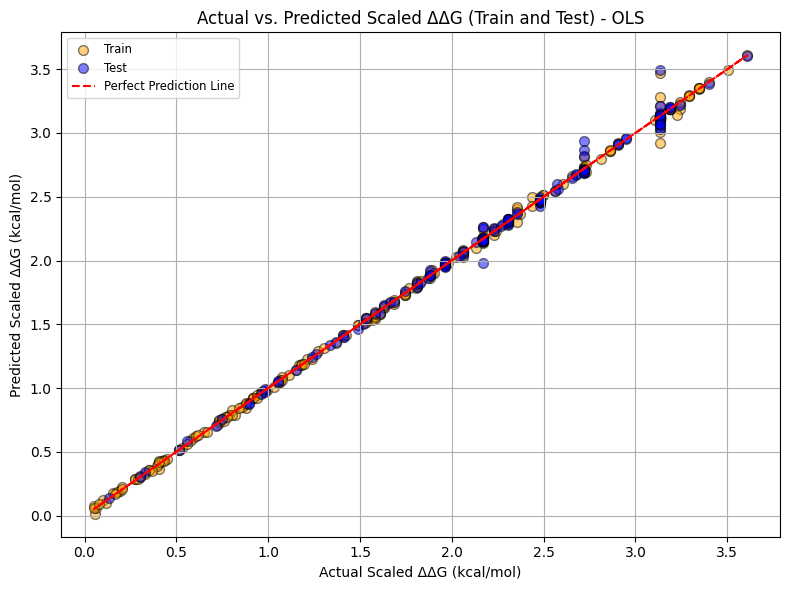

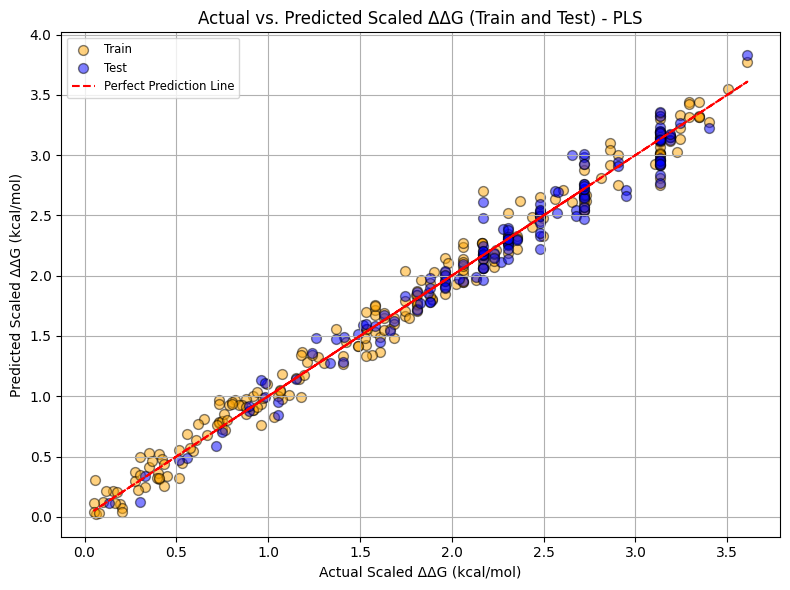

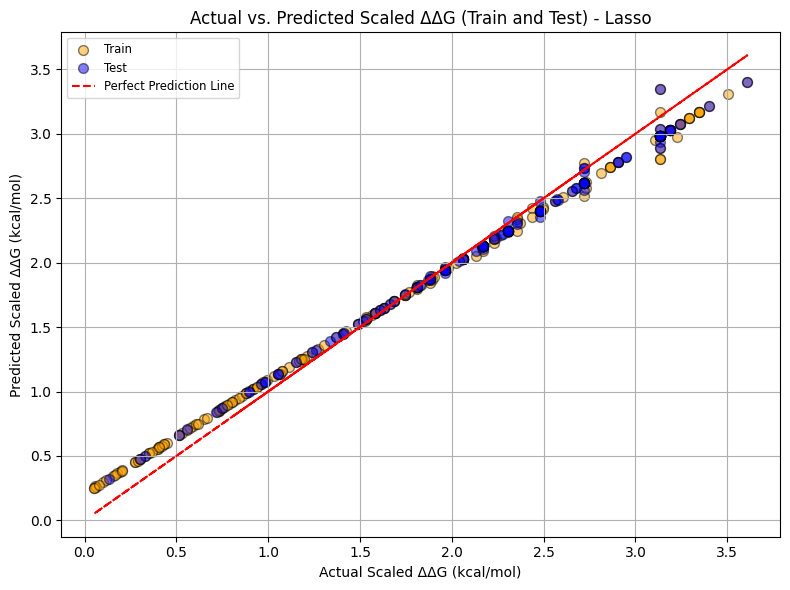

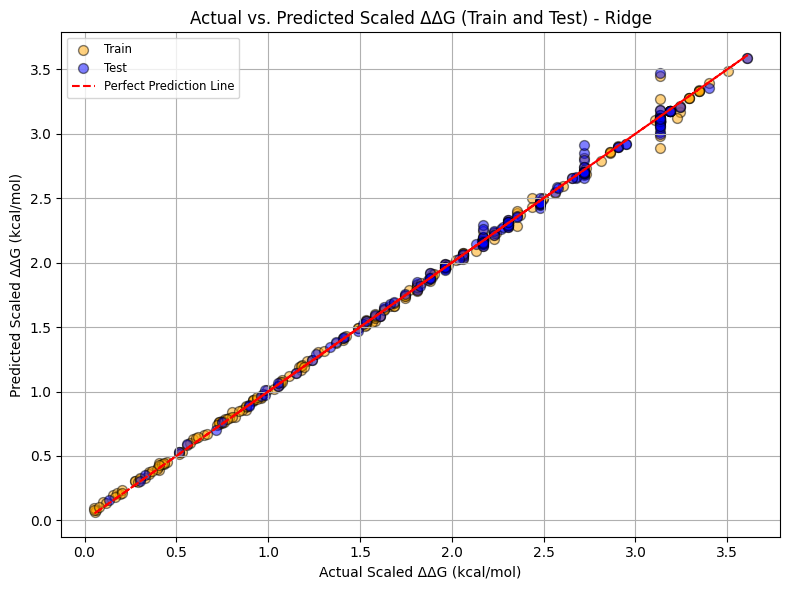

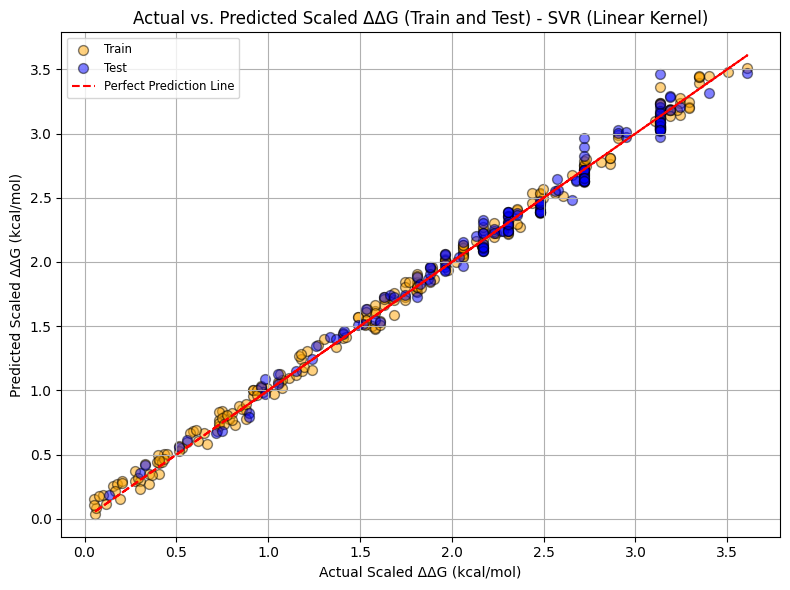

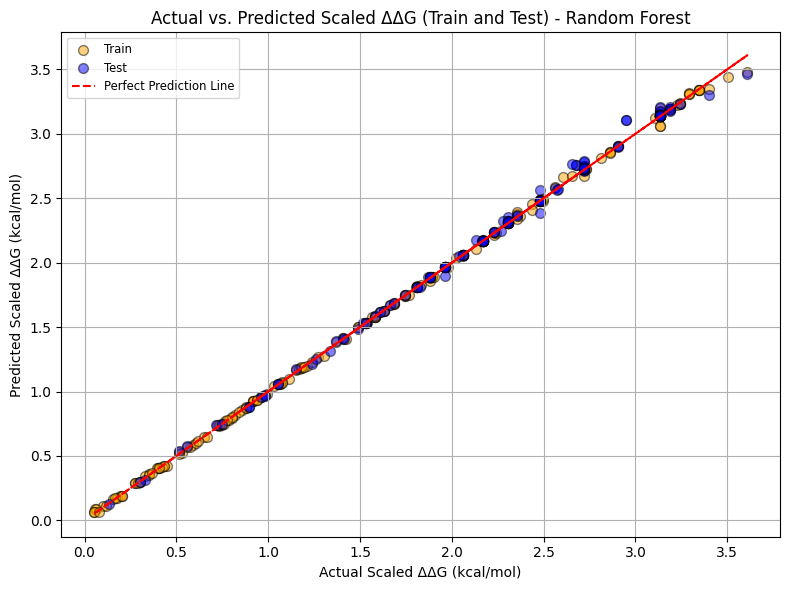

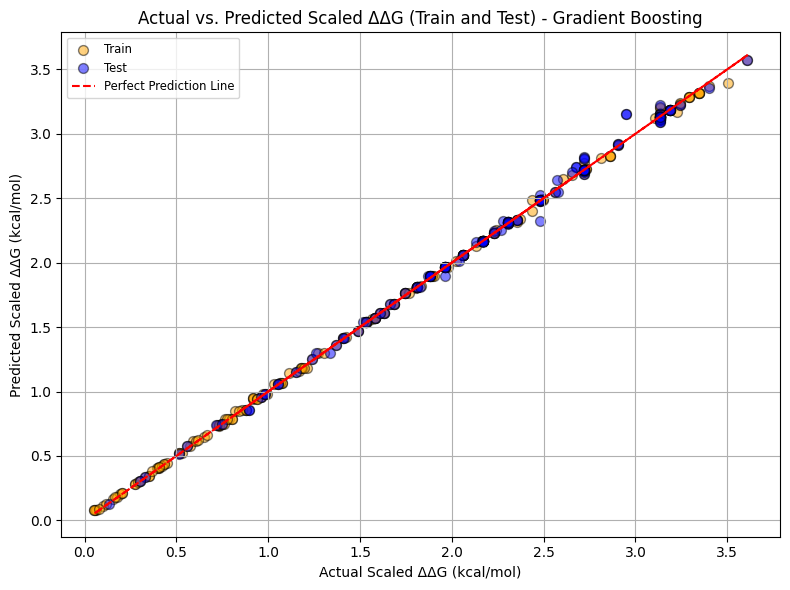

                 Model  Train R²  Train MAE   Test R²  Test MAE
0                  OLS  0.998795   0.016278  0.995506  0.024492
1                  PLS  0.985597   0.092903  0.967679  0.099442
2                Lasso  0.985745   0.098021  0.982087  0.081751
3                Ridge  0.998597   0.021058  0.995754  0.027607
4  SVR (Linear Kernel)  0.995972   0.052231  0.988448  0.063569
5        Random Forest  0.999715   0.008853  0.997807  0.017199
6    Gradient Boosting  0.999682   0.011462  0.997417  0.019883


In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

df_triQ4 = df1[df1['_Alkene_Type'] == 'Tri_Q4'].copy()
df_triQ4 = df_triQ4[df_triQ4['Scaled ΔΔG (kcal/mol)'] != 0].dropna(subset=['Scaled ΔΔG (kcal/mol)', 'ee'])

X = df_triQ4.drop(['ee', '_Alkene_Type', 'Scaled ΔΔG (kcal/mol)'], axis=1) 
y = df_triQ4['Scaled ΔΔG (kcal/mol)'] 

non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor for numeric features
numeric_features = X_train.columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

# Manually bin the target variable for undersampling
bins = np.linspace(y_train.min(), y_train.max(), 5) 
y_binned = pd.cut(y_train, bins=bins, labels=False)

undersampled_indices = []
min_count = y_binned.value_counts().min()  # Minimum count across bins for undersampling

for bin_id in np.unique(y_binned):
    bin_indices = y_binned[y_binned == bin_id].index
    # Only perform undersampling if there are enough samples in the bin
    if len(bin_indices) >= min_count:
        undersampled_indices.extend(np.random.choice(bin_indices, min_count, replace=False))
    else:
        # If the bin has fewer samples than min_count, include all samples from this bin
        undersampled_indices.extend(bin_indices)

X_under = X_train.loc[undersampled_indices]
y_under = y_train.loc[undersampled_indices]

# Apply preprocessing
X_under = preprocessor.fit_transform(X_under)
X_test_processed = preprocessor.transform(X_test)

# Define models and hyperparameter spaces
models = {
    'OLS': (LinearRegression(), {'model__fit_intercept': [True, False]}),
    'PLS': (PLSRegression(), {'model__n_components': randint(1, 5)}),
    'Lasso': (Lasso(), {'model__alpha': uniform(0.01, 1)}),
    'Ridge': (Ridge(), {'model__alpha': uniform(0.01, 10)}),
    'SVR (Linear Kernel)': (SVR(kernel='linear'), {'model__C': uniform(0.1, 10)}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__max_depth': randint(1, 20),
        'model__min_samples_split': randint(2, 10)
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(1, 10),
        'model__min_samples_split': randint(2, 10)
    })
}

# Train models on the undersampled data
results = {'Model': [], 'Train R²': [], 'Train MAE': [], 'Test R²': [], 'Test MAE': []}

for model_name, (model, param_distributions) in models.items():
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    
    # RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=20, 
                                scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=42)

    # Fit the RandomizedSearchCV on the manually undersampled training data
    search.fit(X_under, y_under)

    # Best model from RandomizedSearchCV
    best_pipe = search.best_estimator_

    # Predict on training data
    pred_X_train = best_pipe.predict(X_under)
    r2_train = r2_score(y_under, pred_X_train)
    mae_train = mean_absolute_error(y_under, pred_X_train)
    
    # Predict on test data
    pred_X_test = best_pipe.predict(X_test_processed)
    r2_test = r2_score(y_test, pred_X_test)
    mae_test = mean_absolute_error(y_test, pred_X_test)
    
    # Store results
    results['Model'].append(model_name)
    results['Train R²'].append(r2_train)
    results['Train MAE'].append(mae_train)
    results['Test R²'].append(r2_test)
    results['Test MAE'].append(mae_test)

    # Plot Actual vs Predicted for both Train and Test sets
    plt.figure(figsize=(8, 6))
    plt.scatter(y_under, pred_X_train, color='orange', s=50, alpha=0.5, edgecolor='k', label='Train')
    plt.scatter(y_test, pred_X_test, color='blue', s=50, alpha=0.5, edgecolor='k', label='Test')
    plt.plot(y_under, y_under, color='red', linestyle='--', label='Perfect Prediction Line')
    plt.xlabel('Actual Scaled ΔΔG (kcal/mol)')
    plt.ylabel('Predicted Scaled ΔΔG (kcal/mol)')
    plt.title(f'Actual vs. Predicted Scaled ΔΔG (Train and Test) - {model_name}')
    plt.legend(loc='upper left', frameon=True, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


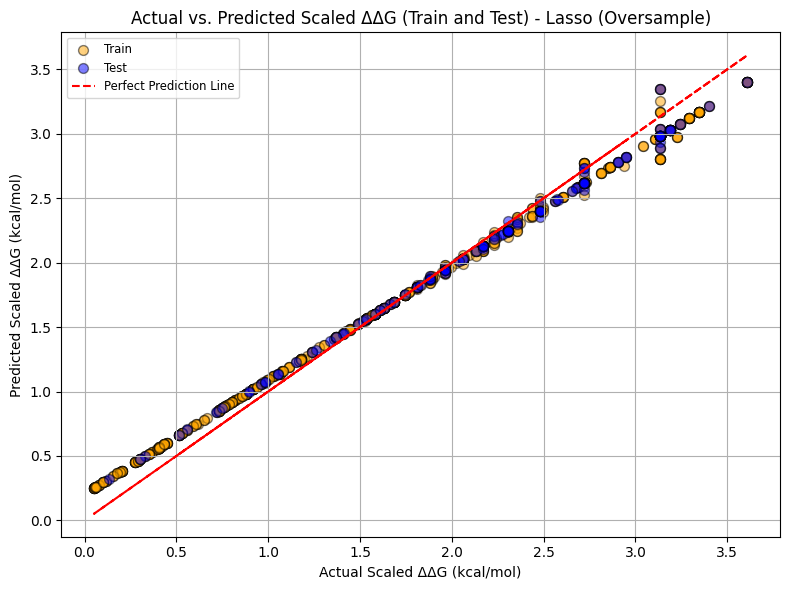

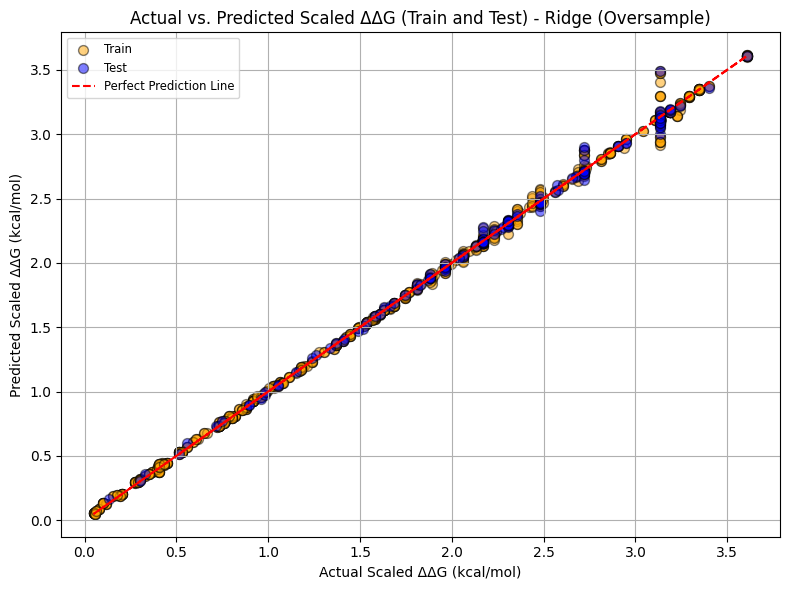

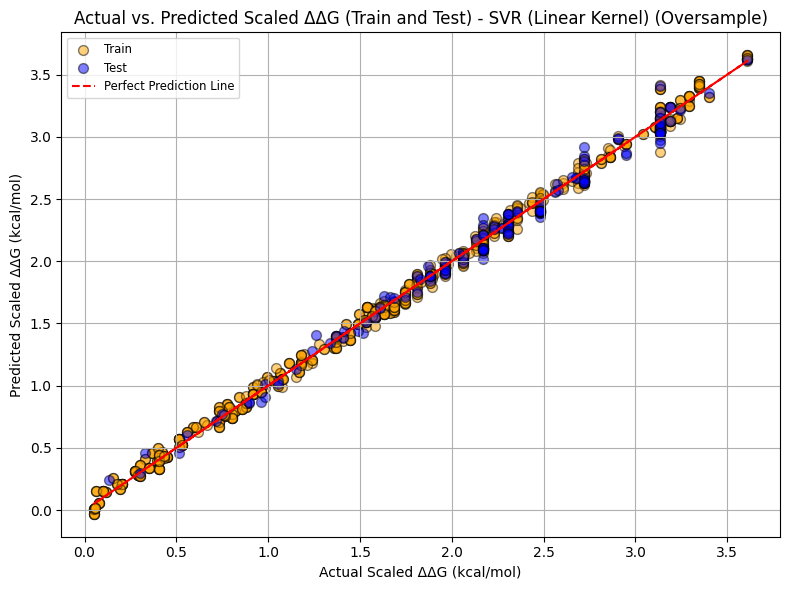

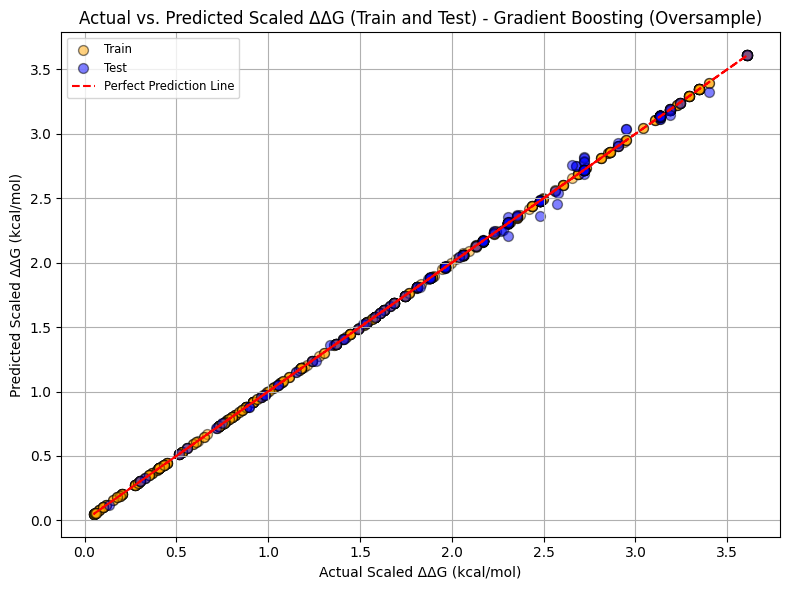

                 Model  Train R²  Train MAE   Test R²  Test MAE
0                  OLS  0.998587   0.016750  0.995981  0.023553
1                  PLS  0.985032   0.094481  0.966314  0.096393
2                Lasso  0.986213   0.096502  0.982314  0.081220
3                Ridge  0.998569   0.017893  0.995963  0.024324
4  SVR (Linear Kernel)  0.996630   0.046131  0.989670  0.060951
5        Random Forest  0.999939   0.002550  0.996834  0.016952
6    Gradient Boosting  0.999999   0.000507  0.998411  0.013268


In [25]:
df_triQ4 = df1[df1['_Alkene_Type'] == 'Tri_Q4'].copy()
df_triQ4 = df_triQ4[df_triQ4['Scaled ΔΔG (kcal/mol)'] != 0].dropna(subset=['Scaled ΔΔG (kcal/mol)', 'ee'])

X = df_triQ4.drop(['ee', '_Alkene_Type', 'Scaled ΔΔG (kcal/mol)'], axis=1) 
y = df_triQ4['Scaled ΔΔG (kcal/mol)'] 

non_numeric_columns = X.select_dtypes(include=['object']).columns
X = X.drop(columns=non_numeric_columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessor for numeric features
numeric_features = X_train.columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

sampling_method = 'oversample' 

bins = np.linspace(y_train.min(), y_train.max(), 5)  # Adjust number of bins if needed
y_binned = pd.cut(y_train, bins=bins, labels=False)

sampled_indices = []
if sampling_method == 'undersample':
    # Perform undersampling within each bin
    min_count = y_binned.value_counts().min()  # Minimum count across bins for undersampling
    for bin_id in np.unique(y_binned):
        bin_indices = y_binned[y_binned == bin_id].index
        if len(bin_indices) >= min_count:
            sampled_indices.extend(np.random.choice(bin_indices, min_count, replace=False))
        else:
            sampled_indices.extend(bin_indices)
elif sampling_method == 'oversample':
    # Perform oversampling within each bin
    max_count = y_binned.value_counts().max()  # Maximum count across bins for oversampling
    for bin_id in np.unique(y_binned):
        bin_indices = y_binned[y_binned == bin_id].index
        # Only perform oversampling if there are samples in the bin
        if len(bin_indices) > 0:
            if len(bin_indices) < max_count:
                sampled_indices.extend(np.random.choice(bin_indices, max_count, replace=True))
            else:
                sampled_indices.extend(bin_indices)

X_sampled = X_train.loc[sampled_indices]
y_sampled = y_train.loc[sampled_indices]

X_sampled = preprocessor.fit_transform(X_sampled)
X_test_processed = preprocessor.transform(X_test)

# Define models and hyperparameter spaces
models = {
    'OLS': (LinearRegression(), {'model__fit_intercept': [True, False]}),
    'PLS': (PLSRegression(), {'model__n_components': randint(1, 5)}),
    'Lasso': (Lasso(), {'model__alpha': uniform(0.01, 1)}),
    'Ridge': (Ridge(), {'model__alpha': uniform(0.01, 10)}),
    'SVR (Linear Kernel)': (SVR(kernel='linear'), {'model__C': uniform(0.1, 10)}),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__max_depth': randint(1, 20),
        'model__min_samples_split': randint(2, 10)
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(1, 10),
        'model__min_samples_split': randint(2, 10)
    })
}

# Train models on the sampled data
results = {'Model': [], 'Train R²': [], 'Train MAE': [], 'Test R²': [], 'Test MAE': []}

for model_name, (model, param_distributions) in models.items():
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])
    
    # RandomizedSearchCV for hyperparameter tuning
    search = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=20, 
                                scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=42)

    # Fit the RandomizedSearchCV on the sampled training data
    search.fit(X_sampled, y_sampled)

    # Best model from RandomizedSearchCV
    best_pipe = search.best_estimator_

    # Predict on training data
    pred_X_train = best_pipe.predict(X_sampled)
    r2_train = r2_score(y_sampled, pred_X_train)
    mae_train = mean_absolute_error(y_sampled, pred_X_train)
    
    # Predict on test data
    pred_X_test = best_pipe.predict(X_test_processed)
    r2_test = r2_score(y_test, pred_X_test)
    mae_test = mean_absolute_error(y_test, pred_X_test)
    
    # Store results
    results['Model'].append(model_name)
    results['Train R²'].append(r2_train)
    results['Train MAE'].append(mae_train)
    results['Test R²'].append(r2_test)
    results['Test MAE'].append(mae_test)

    # Plot Actual vs Predicted for both Train and Test sets
    plt.figure(figsize=(8, 6))
    plt.scatter(y_sampled, pred_X_train, color='orange', s=50, alpha=0.5, edgecolor='k', label='Train')
    plt.scatter(y_test, pred_X_test, color='blue', s=50, alpha=0.5, edgecolor='k', label='Test')
    plt.plot(y_sampled, y_sampled, color='red', linestyle='--', label='Perfect Prediction Line')
    plt.xlabel('Actual Scaled ΔΔG (kcal/mol)')
    plt.ylabel('Predicted Scaled ΔΔG (kcal/mol)')
    plt.title(f'Actual vs. Predicted Scaled ΔΔG (Train and Test) - {model_name} ({sampling_method.capitalize()})')
    plt.legend(loc='upper left', frameon=True, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=500. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories 

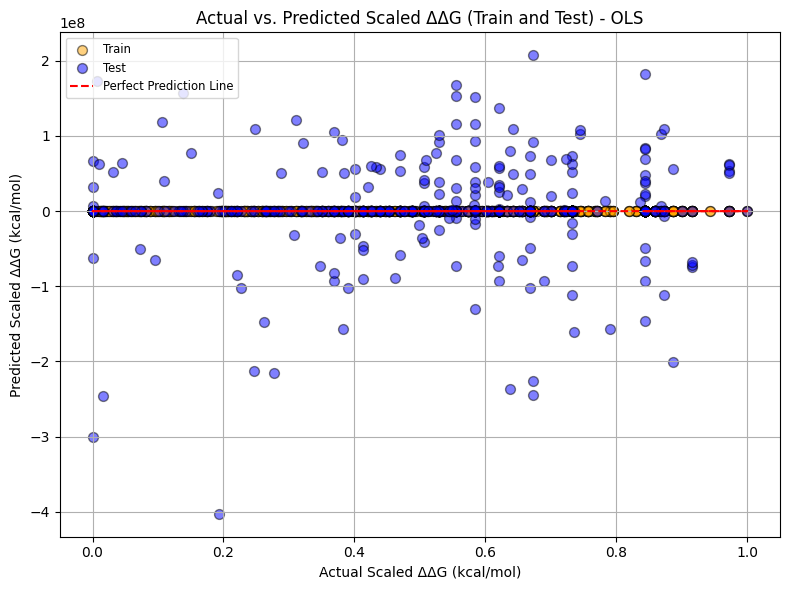

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be en

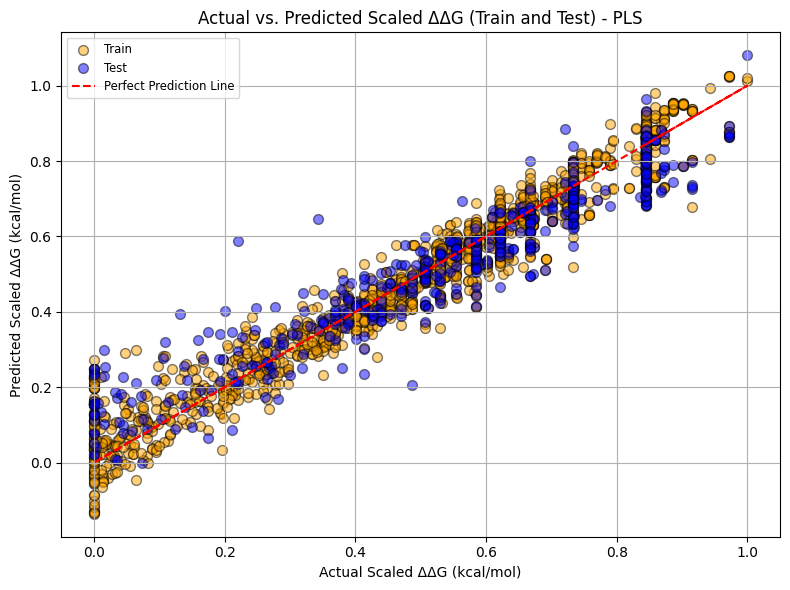

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be en

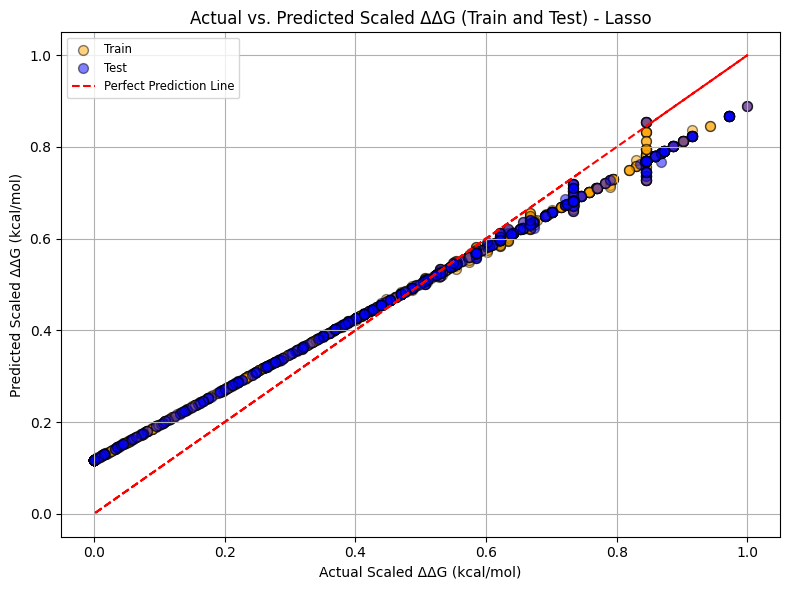

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be en

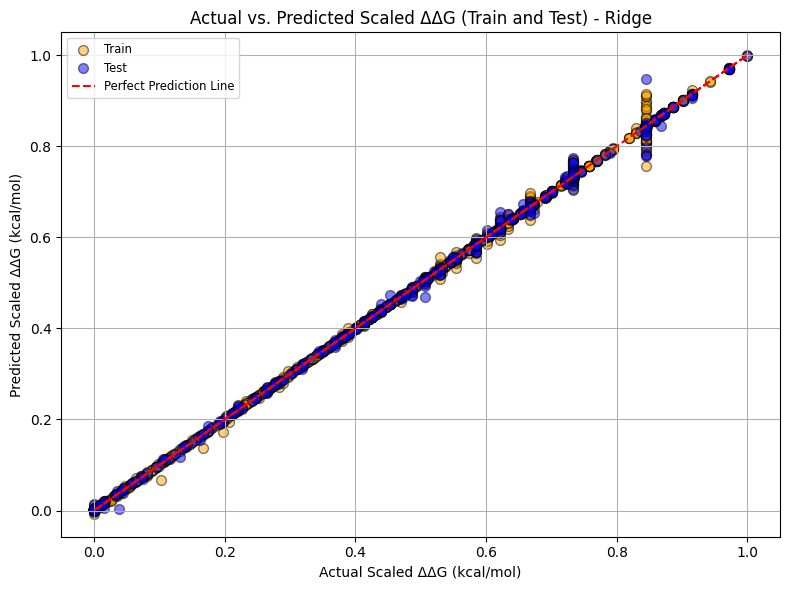

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 24 is smaller than n_iter=500. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categorie

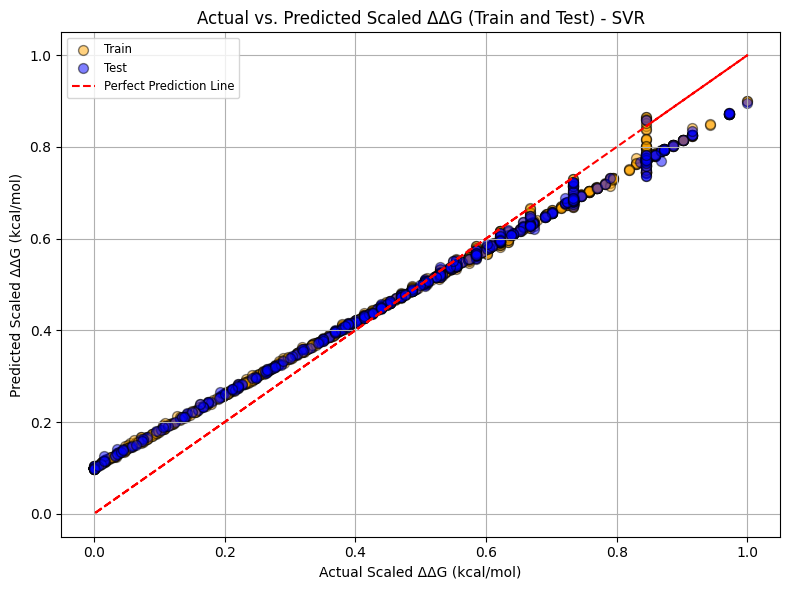

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be en

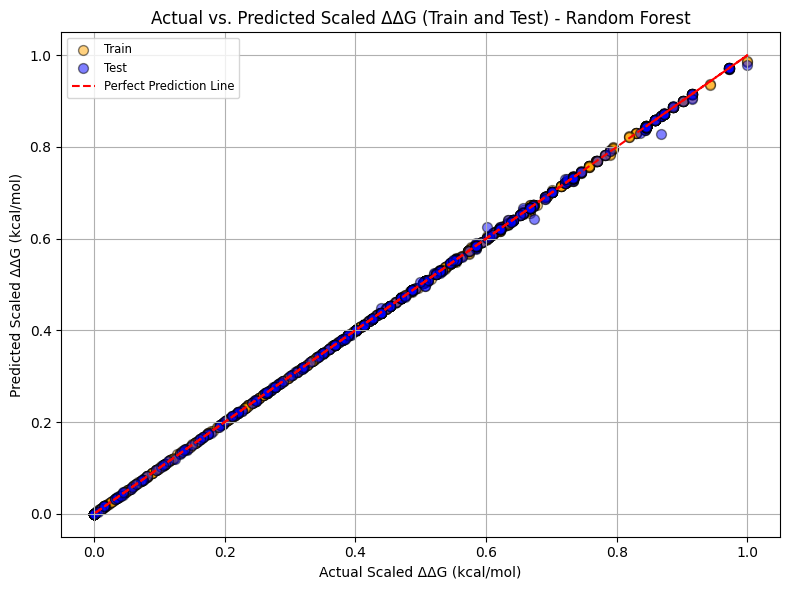

/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be en

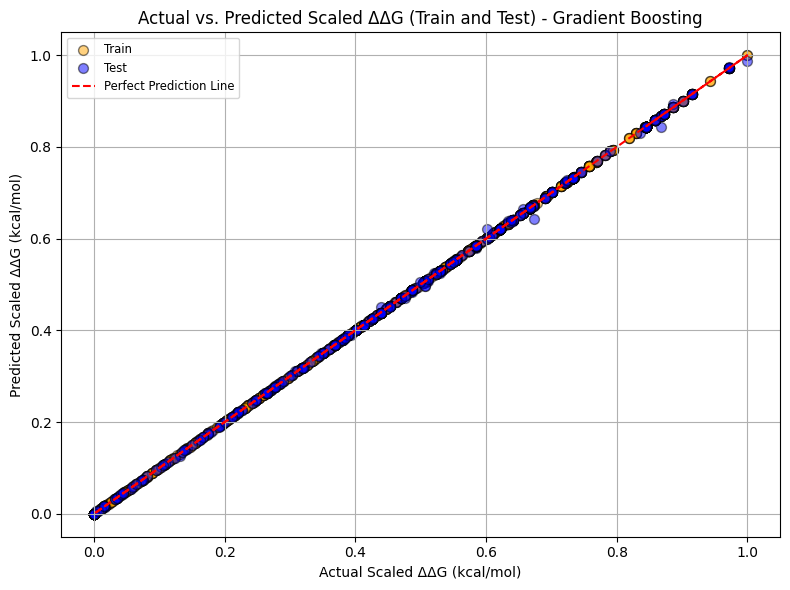

Model  Train R²  Train MAE       Test R²      Test MAE
0                OLS  0.999257   0.002044 -5.472945e+16  2.868895e+07
1                PLS  0.948551   0.042462  8.815974e-01  6.607073e-02
2              Lasso  0.947725   0.047878  9.471604e-01  4.770527e-02
3              Ridge  0.999253   0.002211  9.985321e-01  4.169364e-03
4                SVR  0.957781   0.043637  9.570798e-01  4.329968e-02
5      Random Forest  0.999982   0.000409  9.998246e-01  1.092174e-03
6  Gradient Boosting  1.000000   0.000055  9.998909e-01  7.315185e-04

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'scaled_output_ddG_constant_ee_kcal.xlsx'
df = pd.read_excel(file_path)

# Data preprocessing
# Remove entries where ee is NaN or equals 1, and drop Rxn ID column
df_filtered = df.dropna(subset=['ee'])
df_filtered = df_filtered[df_filtered['ee'] != 1.0]
df_filtered = df_filtered.drop(columns=['Rxn ID'])

# Define feature set (X) and target variable (y)
X = df_filtered.drop(['ee', 'Scaled ΔΔG (kcal/mol)'], axis=1, errors='ignore')
y = df_filtered['Scaled ΔΔG (kcal/mol)']

# Identify categorical columns for encoding
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

# ColumnTransformer with imputation and encoding/scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale y using MinMaxScaler for consistent scaling
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Define models and hyperparameter spaces
models = {
    'OLS': (LinearRegression(), {'model__fit_intercept': [True, False]}),
    'PLS': (PLSRegression(), {'model__n_components': randint(1, 5)}),
    'Lasso': (Lasso(random_state=42), {'model__alpha': uniform(0.01, 1)}),
    'Ridge': (Ridge(random_state=42), {'model__alpha': uniform(0.01, 10)}),
    'SVR': (SVR(), {
        'model__kernel': ['poly', 'rbf', 'linear'],
        'model__degree': [2, 3],
        'model__C': [0.25, 1, 5, 10]
    }),
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__max_depth': randint(1, 20),
        'model__min_samples_split': randint(2, 10)
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'model__n_estimators': randint(10, 200),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(1, 10),
        'model__min_samples_split': randint(2, 10)
    })
}

# Run RandomizedSearchCV with n_iter=500
results_updated = {'Model': [], 'Train R²': [], 'Train MAE': [], 'Test R²': [], 'Test MAE': []}

for model_name, (model, param_distributions) in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    search = RandomizedSearchCV(pipe, param_distributions=param_distributions, n_iter=500, 
                                scoring='neg_mean_absolute_error', n_jobs=-1, cv=5, random_state=42)
    search.fit(X_train, y_train_scaled)
    best_pipe = search.best_estimator_

    # Training performance
    pred_X_train = best_pipe.predict(X_train)
    r2_train = r2_score(y_train_scaled, pred_X_train)
    mae_train = mean_absolute_error(y_train_scaled, pred_X_train)
    
    # Testing performance
    pred_X_test = best_pipe.predict(X_test)
    r2_test = r2_score(y_test_scaled, pred_X_test)
    mae_test = mean_absolute_error(y_test_scaled, pred_X_test)
    
    # Store results
    results_updated['Model'].append(model_name)
    results_updated['Train R²'].append(r2_train)
    results_updated['Train MAE'].append(mae_train)
    results_updated['Test R²'].append(r2_test)
    results_updated['Test MAE'].append(mae_test)

    # Plot Actual vs Predicted for both Train and Test sets
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train_scaled, pred_X_train, color='orange', s=50, alpha=0.5, edgecolor='k', label='Train')
    plt.scatter(y_test_scaled, pred_X_test, color='blue', s=50, alpha=0.5, edgecolor='k', label='Test')
    plt.plot(y_train_scaled, y_train_scaled, color='red', linestyle='--', label='Perfect Prediction Line')
    plt.xlabel('Actual Scaled ΔΔG (kcal/mol)')
    plt.ylabel('Predicted Scaled ΔΔG (kcal/mol)')
    plt.title(f'Actual vs. Predicted Scaled ΔΔG (Train and Test) - {model_name}')
    plt.legend(loc='upper left', frameon=True, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Display results as a DataFrame
results_updated_df = pd.DataFrame(results_updated)
results_updated_df


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Load and preprocess the data
file_path = 'scaled_output_ddG_constant_ee_kcal.xlsx'
df = pd.read_excel(file_path)

# Data preprocessing
df_filtered = df.dropna(subset=['ee'])
df_filtered = df_filtered[df_filtered['ee'] != 1.0]
df_filtered = df_filtered.drop(columns=['Rxn ID'])

X = df_filtered.drop(['ee', 'Scaled ΔΔG (kcal/mol)'], axis=1, errors='ignore')
y = df_filtered['Scaled ΔΔG (kcal/mol)']

# Split based on catalysts and substrates
def train_test_split_by_group(X, y, group_col, test_size=0.2, random_state=42):
    unique_groups = X[group_col].unique()
    train_groups, test_groups = train_test_split(unique_groups, test_size=test_size, random_state=random_state)

    train_idx = X[group_col].isin(train_groups)
    test_idx = X[group_col].isin(test_groups)

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Split data into subsets
catalyst_col = 'Catalyst ID'  # Replace with actual column name
substrate_col = 'Reactant ID'  # Replace with actual column name

# Train on subset of catalysts and substrates
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Test Unseen Catalysts
X_train_catalysts, X_test_catalysts, y_train_catalysts, y_test_catalysts = train_test_split_by_group(
    X, y, catalyst_col, test_size=0.2
)

# Test Unseen Substrates
X_train_substrates, X_test_substrates, y_train_substrates, y_test_substrates = train_test_split_by_group(
    X, y, substrate_col, test_size=0.2
)

# Test Both Unseen Catalysts and Substrates
X_test_both_unseen = X_test_catalysts[X_test_catalysts[substrate_col].isin(X_test_substrates[substrate_col])]
y_test_both_unseen = y[X_test_both_unseen.index]

# Preprocess the data using pipeline
numeric_cols = X.select_dtypes(exclude=['object']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ]
)

# Scale target variable
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Train and evaluate model
def train_and_evaluate(X_train, y_train, X_test, y_test, preprocessor, model):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)

    # Predictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    return r2_train, mae_train, r2_test, mae_test

# Example: Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Train on the general set
r2_train, mae_train, r2_test, mae_test = train_and_evaluate(
    X_train, y_train_scaled, X_test, y_test_scaled, preprocessor, model
)

# Test on unseen catalysts
r2_test_catalysts, mae_test_catalysts, *_ = train_and_evaluate(
    X_train_catalysts, y_train_catalysts, X_test_catalysts, y_test_catalysts, preprocessor, model
)

# Test on unseen substrates
r2_test_substrates, mae_test_substrates, *_ = train_and_evaluate(
    X_train_substrates, y_train_substrates, X_test_substrates, y_test_substrates, preprocessor, model
)

# Test on both unseen
r2_test_both, mae_test_both, *_ = train_and_evaluate(
    X_train, y_train_scaled, X_test_both_unseen, y_test_both_unseen, preprocessor, model
)

# Display results
results = pd.DataFrame({
    'Scenario': ['Train Data', 'Test Unseen Catalysts', 'Test Unseen Substrates', 'Test Both Unseen'],
    'R²': [r2_train, r2_test_catalysts, r2_test_substrates, r2_test_both],
    'MAE': [mae_train, mae_test_catalysts, mae_test_substrates, mae_test_both]
})
print(results)


/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                 Scenario        R²       MAE
0              Train Data  0.999247  0.002338
1   Test Unseen Catalysts  0.999242  0.011041
2  Test Unseen Substrates  0.999238  0.012598
3        Test Both Unseen  0.999247  0.002338


/Users/zhangjiayi/miniconda3/envs/molli-test/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
